https://www.astroexplorer.org/details/ajac8154f13

In [1]:
import sys
sys.path.insert(0, '../code/')
from catalog import get_nexsci_data

df = get_nexsci_data(table_name="ps", clobber=False)
df.head()

Column definitions:  https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
Loaded:  ../data/nexsci_ps.csv


/mnt_ut3/raid_ut3/home/jerome/github/research/project/wakai/notebooks/../code/catalog.py:273: DtypeWarning: Columns (3,4,35,40,45,50,55,60,65,75,123,139,148,153,162,167,183,206,211,216,221,226,231,232,237,242,257,262,267) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp)


,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2,sky_coord.ra,sky_coord.dec
0,OGLE-TR-10 b,b,OGLE-TR-10,NaN,NaN,TIC 130150682,Gaia DR2 4056443366649948160,1,<a refstr=TORRES_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,13.692,13.314,0.121,-0.121,13.314&plusmn;0.121,12.856,NaN,NaN,267.867748,-29.876476
1,TOI-4145 A b,b,TOI-4145 A,NaN,NaN,TIC 279947414,Gaia DR2 568619413331898240,0,<a refstr=EXOFOP_TESS_TOI href=https://exofop....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,10.775&plusmn;0.023,10.380,0.028,-0.028,10.380&plusmn;0.028,10.286,0.021,-0.021,39.429744,80.267384
2,KOI-13 b,b,KOI-13,NaN,NaN,TIC 158324245,Gaia DR2 2130632159134827392,0,<a refstr=BORUCKI_ET_AL__2011 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,9.466&plusmn;0.022,9.455,0.019,-0.019,9.455&plusmn;0.019,9.425,0.014,-0.014,286.971388,46.868246
3,Kepler-44 b,b,Kepler-44,NaN,NaN,TIC 239277658,Gaia DR2 2085222191474854656,0,<a refstr=BONOMO_ET_AL__2011 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,13.340&plusmn;0.026,12.969,0.025,-0.025,12.969&plusmn;0.025,12.878,0.034,-0.034,300.102351,45.762192
4,KOI-13 b,b,KOI-13,NaN,NaN,TIC 158324245,Gaia DR2 2130632159134827392,0,<a refstr=BATALHA_ET_AL__2013 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,9.466&plusmn;0.022,9.455,0.019,-0.019,9.455&plusmn;0.019,9.425,0.014,-0.014,286.971388,46.868246


In [2]:
idx = df['default_flag'] == 1
hostnames = df[idx].hostname.unique()
len(hostnames)

3237

In [84]:
import astropy.units as u

df['pl_rade'] = df['pl_radj']*u.Rjup.to(u.Rearth)
transit = df.query("discoverymethod=='Transit'")

idx = (transit.pl_orbper>0) & (transit.pl_rade>0) & (transit.st_mass>0) & (df['default_flag'] == 1)
transit = transit[idx]

## age

In [85]:
import pandas as pd

distance = 500

fp = "../data/young_validated_planets_TOIs.xlsx"
hosts = pd.read_excel(fp, sheet_name='hosts', skiprows=[1]).dropna(subset=['Host'])
hosts = hosts[hosts.distance<distance]
planets = pd.read_excel(fp, sheet_name='planets', skiprows=[1]).dropna(subset=['Host'])

In [86]:
hostnames = hosts.Host.apply(lambda x: x.lower().replace(' ', ''))
hostnames

0            k2-33
2         toi-1227
3         hip67522
5            aumic
6         v1298tau
8         hd109833
9         koi-7368
10       koi-7913a
11         toi-837
13    kepler-1627a
14          dstuca
15     kepler-1643
17         toi-942
19        hip94235
21         toi-251
22      kepler-970
23     kepler-1928
26         toi-451
27        hd235088
32        toi-2076
34        toi-1807
35        hd110082
37        toi-2048
38        toi-2046
39        toi-1027
40        toi-4562
41         hd18599
43        toi-1683
44         hd63433
46         hd73583
48        hd207496
50        toi-1136
54           k2-25
56          k2-136
57        toi-1201
59           k2-95
60          k2-100
62          k2-101
63          k2-102
64          k2-103
65          k2-104
66          k2-264
67          k2-284
68          k2-233
Name: Host, dtype: object

In [87]:
transit['hostname'] = transit.hostname.apply(lambda x: x.lower().replace(' ', ''))

In [88]:
idx = transit['hostname'].isin(hostnames)
planets_nexsci = transit[idx]
planets_nexsci.shape

(56, 356)

In [89]:
hosts['Age_lower'] = hosts['Age'].apply(lambda x: str(x).split('-')[0]).values
hosts['Age_upper'] = hosts['Age'].apply(lambda x: str(x).split('-')[1]).values

In [90]:
planets.query("Host=='V1298Tau'")

,Planet,Host,TOI,Cluster/,Age,Host Teff,Host radius,Host mass,RA,DEC,Planet radius,Planet period,Planet mass,distance,TESS,Reference
6,V1298Tau c,V1298Tau,NaN,Tau-Aur,24-32,4970±120,1.314+0.052-0.064,1.10±0.05,61.331654,20.157032,5.59+0.36-0.32,8.24958±0.00072,NaN,108.199,9.4901,NaN
7,V1298Tau d,V1298Tau,NaN,Tau-Aur,24-32,4970±120,1.314+0.052-0.064,1.10±0.05,61.331654,20.157032,6.41+0.45-0.40,12.4032±0.0015,NaN,108.199,9.4901,NaN
8,V1298Tau b,V1298Tau,NaN,Tau-Aur,24-32,4970±120,1.314+0.052-0.064,1.10±0.05,61.331654,20.157032,10.27+0.58-0.53,24.1396±0.0018,NaN,108.199,9.4901,NaN
9,V1298Tau e,V1298Tau,NaN,Tau-Aur,24-32,4970±120,1.314+0.052-0.064,1.10±0.05,61.331654,20.157032,9.940±0.390,49,NaN,108.199,9.4901,NaN


In [91]:
planets_nexsci.query("hostname=='v1298tau'")

,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2,sky_coord.ra,sky_coord.dec
5187,V1298 Tau b,b,v1298tau,NaN,NaN,TIC 15756231,Gaia DR2 51886335968692480,1,<a refstr=DAVID_ET_AL__2019 href=https://ui.ad...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,8.687&plusmn;0.023,8.191,0.023,-0.023,8.191&plusmn;0.023,8.094,0.021,-0.021,61.331654,20.157032
5188,V1298 Tau c,c,v1298tau,NaN,NaN,TIC 15756231,Gaia DR2 51886335968692480,1,<a refstr=DAVID_ET_AL__2019 href=https://ui.ad...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,8.687&plusmn;0.023,8.191,0.023,-0.023,8.191&plusmn;0.023,8.094,0.021,-0.021,61.331654,20.157032
5189,V1298 Tau d,d,v1298tau,NaN,NaN,TIC 15756231,Gaia DR2 51886335968692480,1,<a refstr=DAVID_ET_AL__2019 href=https://ui.ad...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,8.687&plusmn;0.023,8.191,0.023,-0.023,8.191&plusmn;0.023,8.094,0.021,-0.021,61.331654,20.157032
5331,V1298 Tau e,e,v1298tau,NaN,NaN,TIC 15756231,Gaia DR2 51886335968692480,1,<a refstr=FINOCIETY_ET_AL__2023 href=https://u...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,8.687&plusmn;0.023,8.191,0.023,-0.023,8.191&plusmn;0.023,8.094,0.021,-0.021,61.331654,20.157032


toi-837 8.3249113 9.168946237907841
hip67522 6.959503 10.065664696382935
dstuca 8.138268 5.705371192047789
toi-1227 27.36397 9.572469544221633
v1298tau 24.1396 10.267426349539832
v1298tau 8.24958 5.593281384738401
v1298tau 12.4032 6.411536978096925
v1298tau 53.5 9.975992850535427
hd109833 9.188526 2.8919170285821796
hd109833 13.900148 2.589274548846835
toi-942 4.32421 3.889516313635722
toi-942 10.156272 4.67414496480143
kepler-1643 5.342657 2.320259011304307
koi-7368 6.8430344 2.219378184725859
koi-7913a 24.278553 2.342676972766184
k2-33 5.424865 5.044041328922407


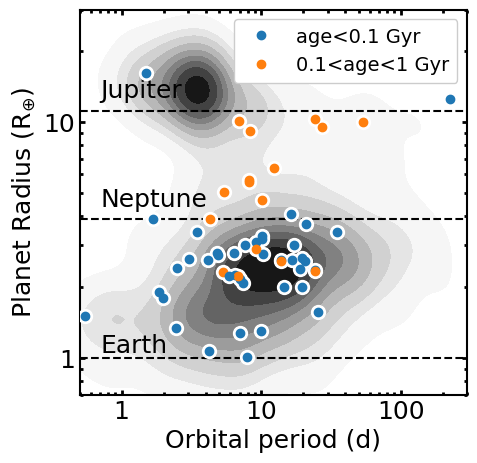

In [133]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from collections import OrderedDict
pl.rcParams['font.size'] = 18

x = 'pl_orbper'
y = 'pl_rade'
idx = np.ones_like(df[x])

porb_lims = (0.5,300)
rp_lims = (0.7,30)

# figsize=None
figsize=(5,5)
fig, ax = pl.subplots(figsize=figsize)

###NExSci
_ = sb.kdeplot(data=df, 
               x=x, 
               y=y,  
               cmap='gray_r', 
               #n_levels=8, 
               log_scale=True, 
               fill=True, 
               ax=ax, 
               zorder=-1
              )
###planets
#periods = planets['Planet period'].str.split(r'±|\+|-', expand=True)[0].astype(float)
periods = planets_nexsci['pl_orbper']
#radii = planets['Planet radius'].str.split(r'±|\+|-', expand=True)[0].astype(float)
radii = planets_nexsci['pl_rade']
#names = planets.Host.str.lower().replace(' ', '').tolist()
names = planets_nexsci['hostname']

for xx,yy,n in zip(periods, radii, names):
    idx = hostnames==n
    d = hosts[idx].squeeze()
    if len(d)>0:
        age = float(d.Age.split('-')[1])
        if age<100:
            print(n,xx,yy)
            color = 'C1'
            lbl = 'age<0.1 Gyr'
        else:
            # print(n, xx, yy)
            color = 'C0'
            lbl = '0.1<age<1 Gyr'
        ax.plot(xx, yy, 'o', label=lbl, c=color, zorder=11)
    #     #white outline
        ax.plot(xx, yy, 'o', c='w', label='_nolegend_', ms=10, zorder=10)
    # else:
    #     print(xx,yy,n)
    
###axes
ax.set_xlim(*porb_lims)
ax.set_ylim(*rp_lims)
ax.set_ylabel('Planet Radius ('+r'R$_{\oplus}$)')
ax.set_xlabel('Orbital period (d)')
ax.tick_params(direction='in', which='both', width=2, bottom=True, top=True, left=True, right=True)
lw=1.5
ax.spines['left'].set_linewidth(lw)
ax.spines['right'].set_linewidth(lw)
ax.spines['top'].set_linewidth(lw)
ax.spines['bottom'].set_linewidth(lw)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

### labels
dx = 0.7
alpha = 1
Rearth = 1
ax.axhline(Rearth, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rearth+0.05, 'Earth', alpha=alpha)
Rnep = 3.88
ax.axhline(Rnep, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rnep+0.5, 'Neptune', alpha=alpha)
Rjup = 11.2
ax.axhline(Rjup, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rjup+1.5, 'Jupiter', alpha=alpha)
### legend
handles, labels = pl.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
pl.legend(by_label.values(), 
          list(by_label.keys())[::-1], 
          fontsize=14,
          framealpha=1,
          bbox_to_anchor=(1.0, 1.0)
         )
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [102]:
planets_nexsci.query("pl_rade>10")[['pl_name','pl_rade','pl_orbper']]

,pl_name,pl_rade,pl_orbper
1327,HIP 67522 b,10.065665,6.959503
5187,V1298 Tau b,10.267426,24.139600
8650,TOI-4562 b,12.531640,225.117810
9919,TOI-2046 b,16.140932,1.497184


In [94]:
fig.savefig(f'young_planets_{distance}pc_square.pdf', bbox_inches='tight', dpi=100)

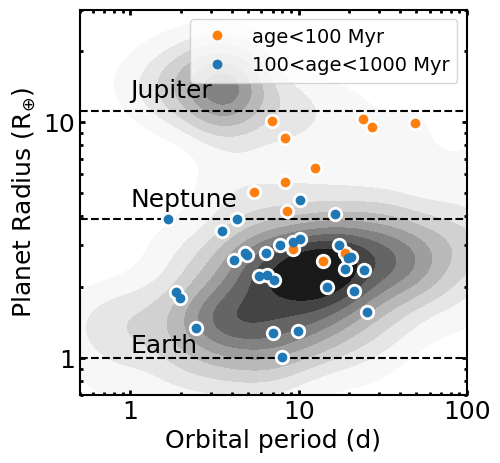

In [14]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from collections import OrderedDict
pl.rcParams['font.size'] = 18

x = 'pl_orbper'
y = 'pl_rade'
idx = np.ones_like(df[x])

porb_lims = (0.5,100)
rp_lims = (0.7,30)

# figsize=None
figsize=(5,5)
fig, ax = pl.subplots(figsize=figsize)

###NExSci
_ = sb.kdeplot(data=df, 
               x=x, 
               y=y,  
               cmap='gray_r', 
               #n_levels=8, 
               log_scale=True, 
               fill=True, 
               ax=ax, 
               zorder=-1
              )
###planets
periods = planets['Planet period'].str.split('±|\+|-', expand=True)[0].astype(float)
radii = planets['Planet radius'].str.split('±|\+|-', expand=True)[0].astype(float)
names = planets.Host.tolist()

for xx,yy,n in zip(periods, radii, names):
    d = hosts[hosts.Host==n].squeeze()
    if len(d)>0:
        age = float(d.Age.split('-')[1])
        if age<100:
            color = 'C1'
            lbl = 'age<0.1 Gyr'
        else:
            color = 'C0'
            lbl = '0.1<age<1 Gyr'
        ax.plot(xx, yy, 'o', label=lbl, c=color, zorder=11)
    #     #white outline
        ax.plot(xx, yy, 'o', c='w', label='_nolegend_', ms=10, zorder=10)
    
###axes
ax.set_xlim(*porb_lims)
ax.set_ylim(*rp_lims)
ax.set_ylabel('Planet Radius ('+r'R$_{\oplus}$)')
ax.set_xlabel('Orbital period (d)')
ax.tick_params(direction='in', which='both', width=2, bottom=True, top=True, left=True, right=True)
lw=1.5
ax.spines['left'].set_linewidth(lw)
ax.spines['right'].set_linewidth(lw)
ax.spines['top'].set_linewidth(lw)
ax.spines['bottom'].set_linewidth(lw)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

### labels
dx = 1
alpha = 1
Rearth = 1
ax.axhline(Rearth, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rearth+0.05, 'Earth', alpha=alpha)
Rnep = 3.88
ax.axhline(Rnep, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rnep+0.5, 'Neptune', alpha=alpha)
Rjup = 11.2
ax.axhline(Rjup, 0, 1, c='k', ls='--', alpha=alpha, zorder=0)
ax.text(dx, Rjup+1.5, 'Jupiter', alpha=alpha)
### legend
handles, labels = pl.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys(), fontsize=14)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))